In [1]:
# Import dependencies
import glob
import pickle

import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
% matplotlib inline


from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC


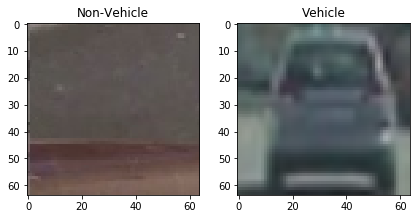

In [2]:
# Load and plot vehicle and non-vehicle data
non_vehicle = "non-vehicles/Extras/extra5.png"
vehicle = "vehicles/GTI_Far/image0005.png"

image_non_vehicle = mpimg.imread(non_vehicle)
image_vehicle = mpimg.imread(vehicle)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(image_non_vehicle)
ax1.set_title('Non-Vehicle')
ax2.imshow(image_vehicle)
ax2.set_title('Vehicle')
f.tight_layout()


In [14]:
# HOG and other features
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features


def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


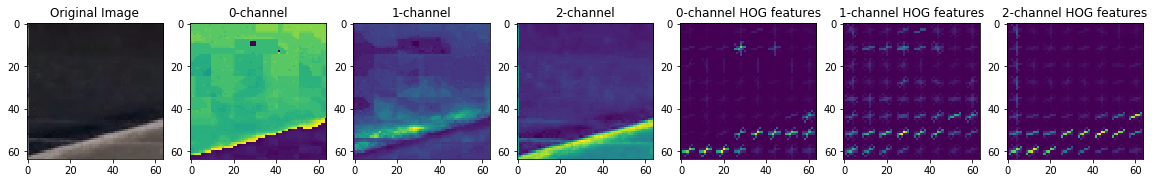

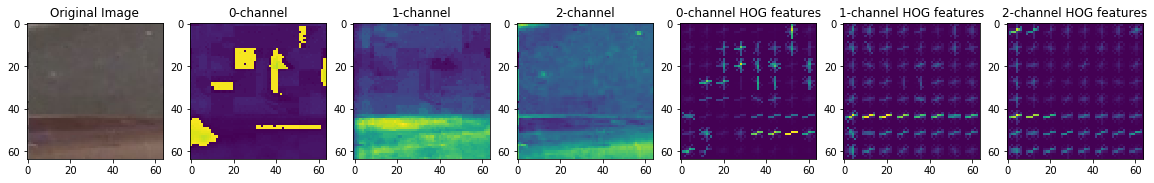

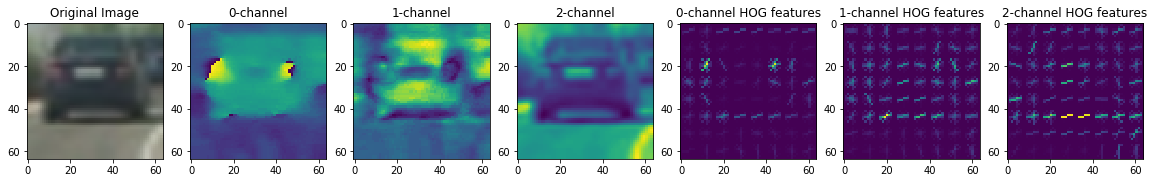

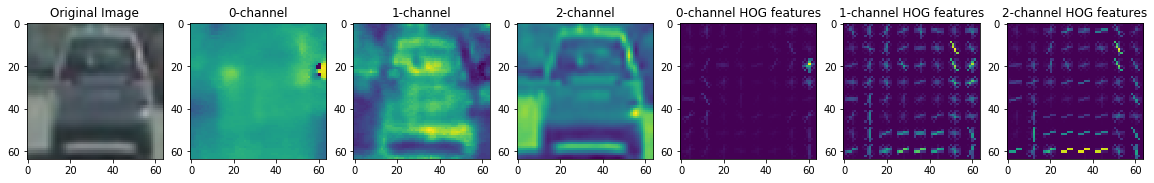

In [15]:
# Plot channels and HOG features

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


non_vehicle_5 = "non-vehicles/Extras/extra5.png"
non_vehicle_3 = "non-vehicles/Extras/extra3.png"
vehicle_5 = "vehicles/GTI_Far/image0005.png"
vehicle_1 = "vehicles/GTI_Far/image0001.png"
def display_hog_features(file):

    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(20, 5))

    image = mpimg.imread(file)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ax1.imshow(image)
    ax1.set_title('Original Image')
    
    ax2.imshow(feature_image[:, :, 0])
    ax2.set_title('0-channel')
    
    ax3.imshow(feature_image[:, :, 1])
    ax3.set_title('1-channel')
    
    ax4.imshow(feature_image[:, :, 2])
    ax4.set_title('2-channel')
    
    features_c0, hog_image_c0 = get_hog_features(img=feature_image[:, :, 0],
                                            orient=orient,
                                            pix_per_cell=pix_per_cell,
                                            cell_per_block=cell_per_block,
                                                vis=True)
    
    ax5.imshow(hog_image_c0)
    ax5.set_title('0-channel HOG features')
    
    features_c1, hog_image_c1 = get_hog_features(img=feature_image[:, :, 1],
                                            orient=orient,
                                            pix_per_cell=pix_per_cell,
                                            cell_per_block=cell_per_block,
                                                vis=True)

    ax6.imshow(hog_image_c1)
    ax6.set_title('1-channel HOG features')

    features_c2, hog_image_c2 = get_hog_features(img=feature_image[:, :, 2],
                                            orient=orient,
                                            pix_per_cell=pix_per_cell,
                                            cell_per_block=cell_per_block,
                                                vis=True)

    
    ax7.imshow(hog_image_c2)
    ax7.set_title('2-channel HOG features')

display_hog_features(non_vehicle_3)
display_hog_features(non_vehicle_5)
display_hog_features(vehicle_1)
display_hog_features(vehicle_5)

In [18]:
# Extract all features: HOG, histogram, binned colors
def extract_features(imgs, color_space=color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, orient=orient,
                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                     hist_feat=hist_feat, 
                     hog_feat=hog_feat):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [25]:
# Train classifier

print("color_space: ", color_space) # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)

carFiles = glob.glob("vehicles/*/*.png", recursive=True)
print("Loading car files")
cars = []
for image in carFiles:
    cars.append(image)
print("Loaded car files")
nonCarFiles = glob.glob("non-vehicles/*/*.png", recursive=False)
notcars = []
print("Loading non-car files")
for image in nonCarFiles:
    notcars.append(image)


print("Extracting car features")
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
print("Extracting non-car features")
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=2017)
print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
filename = "svm.pkl"
joblib.dump(svc, filename)
pickle.dump(X_scaler, open("scalar.pkl","wb"))
svm = svc

color_space:  HSV
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (64, 64)
hist_bins:  64
spatial_feat:  True
hist_feat:  True
hog_feat:  True
Loading car files
Loaded car files
Loading non-car files
Extracting car features
Extracting non-car features
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 17772
Test Accuracy of SVC =  0.9907


In [129]:
# Sliding Window

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), window_list=None):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    if window_list == None:
        window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)


def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    # 8) Return windows for positive detections
    return(on_windows)



# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def get_hot_windows(image, previous=None, count=0):
    
    
    xmin = None
    xmax = None
    
    if count % 2 != 0:
        if previous is not None:
            for car_number in range(1, previous[1]+1):
                nonzero = (previous[0] == car_number).nonzero()
                nonzerox = np.array(nonzero[1])
                if xmin is None:
                    xmin = np.min(nonzerox)
                else:
                    xmin = min(np.min(nonzerox),xmin)
                if xmax is None:
                    xmax = np.max(nonzerox)
                else:
                    xmax = max(np.max(nonzerox),xmax)
                
    if xmin is not None and xmin > 50:
        xmin = xmin - 50
    if xmax is not None and xmax + 50 < image.shape[1]:
        xmax = xmax + 50
                
    x_start_stop = [xmin, xmax]


    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=[375, 675],
                             xy_window=(64, 64), xy_overlap=(0.8, 0.8),window_list=None)

    hot_windows = search_windows(image, windows, classifier, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    return(hot_windows)

(720, 1280, 3)
510


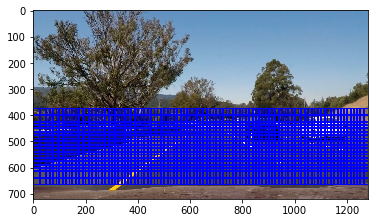

In [133]:
print(image.shape)
wndws_v1 = slide_window(image, x_start_stop=[0, 1300], y_start_stop=[375, 650],
                             xy_window=(64, 64), xy_overlap=(0.6, 0.6), window_list=None)
wndws_v2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[450, 650],
                             xy_window=(120, 120), xy_overlap=(0.6, 0.6),window_list=None)

# # print(wndws_v2)
# wndws =  np.concatenate((wndws_v1, wndws_v2), axis=1)
# print(wndws)
# # img_features.append(hog_features)

# #     # 9) Return concatenated array of features
# #     return np.concatenate(img_features)
output_windows = draw_boxes(image, wndws_v1)

plt.imshow(output_windows)
print(len(wndws_v1))

In [30]:
# Load pickle files

clf_pickle = joblib.load(open('svm.pkl', "rb"))
classifier = clf_pickle

scalar_pickle = pickle.load(open('scalar.pkl', "rb"))
X_scaler = scalar_pickle



In [115]:
class Memory:
    def __init__(self):
        self.previousHeat = []
        self.labels = []
        self.iteration = 0 
        self.averageCount = 10

memory = Memory()

def detect_vehicles(image, showheatmap=False, memory=None):
    draw_image = np.copy(image)
    image = image.astype(np.float32) / 255
    
    count = 0 
    previousLabels = None

    if memory is not None:
        previousLabels = memory.labels
        count = memory.iteration
    
    hot_windows = get_hot_windows(image, previous=previousLabels, count=count)
    
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heatmap = add_heat(heatmap=heat, bbox_list=hot_windows)

    if memory is None:
        memory = Memory()
        
    if len(memory.previousHeat) < memory.averageCount:
        for i in range(memory.averageCount):
            memory.previousHeat.append(np.copy(heatmap).astype(np.float))
        
    memory.previousHeat[memory.iteration%memory.averageCount] = heatmap
    total = np.zeros(np.array(memory.previousHeat[0]).shape)
    
    for value in memory.previousHeat:
        total = total + np.array(value)
    
    averageHeatMap = total/memory.averageCount
    
    averageHeatMap = apply_threshold(averageHeatMap, 3)

    labels = label(averageHeatMap)
    
    memory.labels = labels
    memory.iteration = memory.iteration + 1
    
    window_img = draw_labeled_bboxes(draw_image, labels)

    return(window_img, heatmap, averageHeatMap)

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return(heatmap)


def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return(heatmap)

def draw_labeled_bboxes(img, labels):
  
    filterd_boxes = []
    
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if abs(np.min(nonzerox)-np.max(nonzerox)) > 10 and abs(np.min(nonzeroy)-np.max(nonzeroy)) > 10:
            filterd_boxes.append([np.min(nonzerox), np.min(nonzeroy),np.max(nonzerox), np.max(nonzeroy)])
    
    # Find overlapping boxes and extend to min and max values
    final_values = []
    for i in filterd_boxes:
        final_value = i 
        for j in filterd_boxes:
            if i != j:
                # There should not be any overlap
                if (not(i[3] < j[1] or i[1] > j[3] or i[2] < j[0] or i[0] > j[2])):
                    final_value = [min(final_value[0],j[0]),
                                   min(final_value[1],j[1]),
                                   max(final_value[2],j[2]),
                                   max(final_value[3],j[3])]
        cv2.rectangle(img,(final_value[0],final_value[1]),(final_value[2],final_value[3]), (0,0,255), 6)        
    return(img)

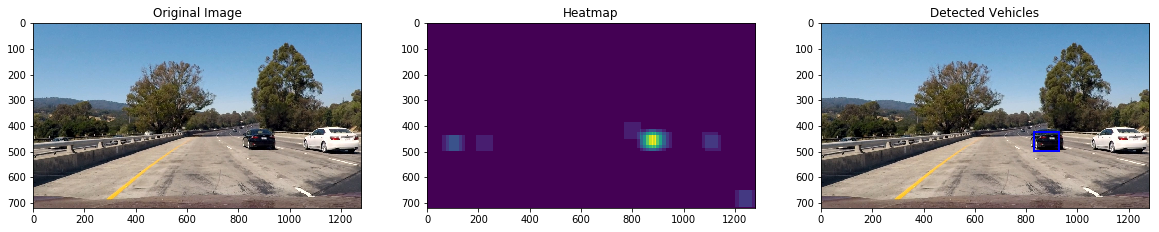

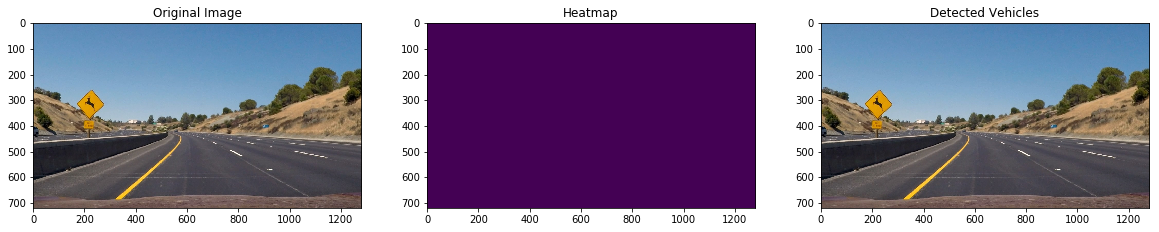

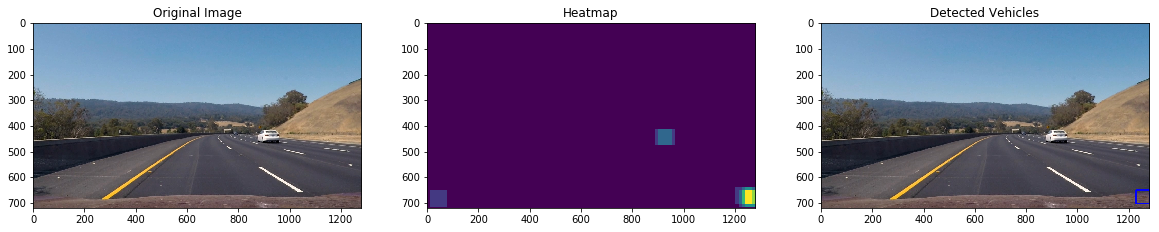

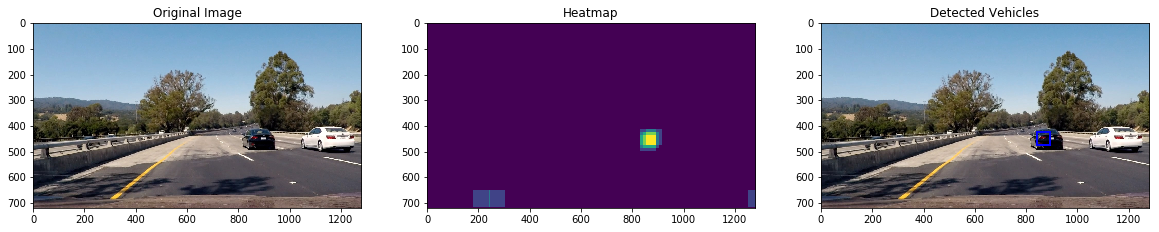

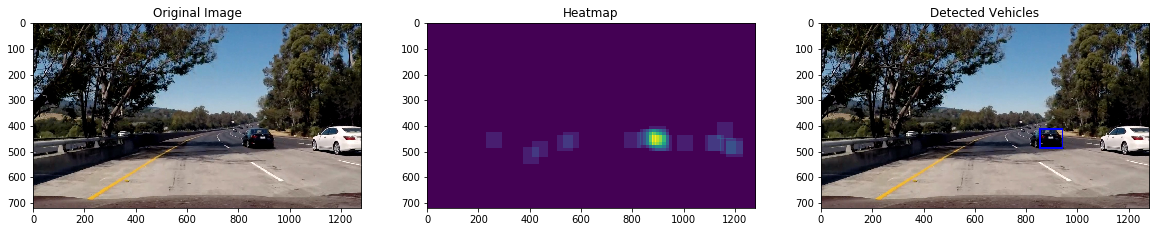

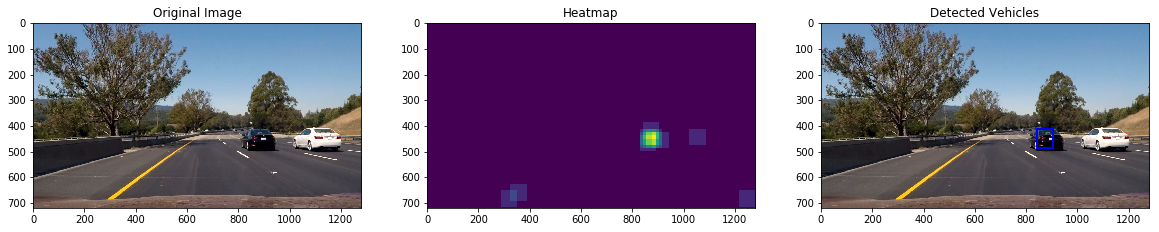

In [134]:
# Test flow on images
images = glob.glob("test_images/*")
for file in images:
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    image = mpimg.imread(file)
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    ax1.imshow(image)
    ax1.set_title('Original Image')
    
    img, img_heat, memory = detect_vehicles(image=image, memory=None)
    
    ax2.imshow(img_heat)
    ax2.set_title('Heatmap')

    ax3.imshow(img)
    ax3.set_title('Detected Vehicles')


In [36]:
def process_image(image):
    img, img_heat, memory = detect_vehicles(image=image, memory=None)
    return(img)

_ = process_image(image)

In [ ]:
import imageio
from imageio.plugins import ffmpeg

# imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_video_v6.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)